In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [10]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

Credentials are already in use. The existing account in the session will be replaced.


[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [11]:
provider = q.IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [12]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

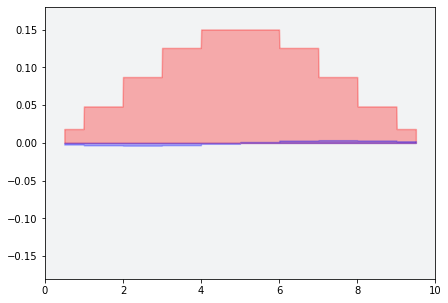

In [13]:
cmd_def.get('x', qubits=[0]).instructions[0][1].command.draw(scaling=0.18)

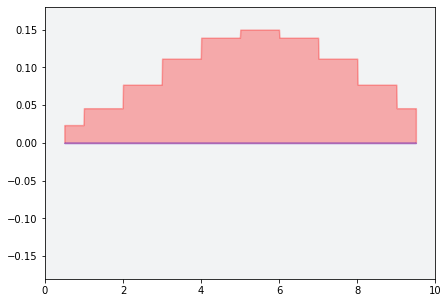

In [14]:
# Approximate X as a gaussian pulse:
DURATION = 10
AMP = 0.15
SIGMA = 2.6
q.pulse.pulse_lib.gaussian(duration=DURATION, amp=AMP, sigma=SIGMA).draw(scaling=0.18)

------------

In [15]:
MEASUREMENT_START_TIMESTEP = 30

In [16]:
# just measure
schedule = q.pulse.Schedule()
schedule |= measure << MEASUREMENT_START_TIMESTEP

job = q.execute(schedule, backend=backend, shots=1000)
print(job.job_id())

5daf349524a011001959eea3


In [17]:
# X, then measure
schedule = q.pulse.Schedule()
schedule |= cmd_def.get('x', qubits=[0])
schedule |= measure << MEASUREMENT_START_TIMESTEP

job = q.execute(schedule, backend=backend, shots=1000)
print(job.job_id())

5daf349a140f700018632a0a


In [18]:
# X, X, then measure
schedule = q.pulse.Schedule()
schedule |= cmd_def.get('x', qubits=[0])
schedule |= cmd_def.get('x', qubits=[0]) << schedule.duration
schedule |= measure << MEASUREMENT_START_TIMESTEP

job = q.execute(schedule, backend=backend, shots=1000)
print(job.job_id())

5daf34a0140f700018632a0c


In [19]:
schedules = []

for scaling_factor in [0.2, 0.4, 0.6, 0.8, 1.0]:
    # X, then pulse at 1-2 frequency, then X, then measure
    schedule = q.pulse.Schedule()
    schedule |= cmd_def.get('x', qubits=[0])

    freq = config.dt * 0.304  # anharmonicity is 304 MHz. In units of dt, we have .304/ns * config.dt/ns
    wave_samples = q.pulse.pulse_lib.cos(duration=DURATION, amp=1, freq=freq).samples - 1j * q.pulse.pulse_lib.sin(
                duration=DURATION, amp=1, freq=freq).samples
    # use amplitude of AMP / sqrt(2) for 1->2 transition
    gaussian_samples = q.pulse.pulse_lib.gaussian(
        duration=DURATION, amp=AMP * scaling_factor / np.sqrt(2), sigma=SIGMA).samples
    schedule |= q.pulse.SamplePulse(gaussian_samples * wave_samples)(system.qubits[0].drive) << schedule.duration

    schedule |= cmd_def.get('x', qubits=[0]) << schedule.duration

    schedule |= measure << MEASUREMENT_START_TIMESTEP
    
    schedules.append(schedule)

job = q.execute(schedules, backend=backend, shots=1000)
print(job.job_id())

5daf3502c1592500190bdced


In [20]:
job_ids = ['5daf349524a011001959eea3', '5daf349a140f700018632a0a', '5daf34a0140f700018632a0c', '5daf3502c1592500190bdced']
jobs = [provider.backends.retrieve_job(job_id) for job_id in job_ids]

In [21]:
# just measure
job = jobs[0]
counts = job.result().get_counts()
frac_ones = sum([value for (key,value) in counts.items() if key[-1] == '1']) / 1000
print('frac_ones is %s' % frac_ones)

frac_ones is 0.092


In [22]:
# X, then measure
job = jobs[1]
counts = job.result().get_counts()
frac_ones = sum([value for (key,value) in counts.items() if key[-1] == '1']) / 1000
print('frac_ones is %s' % frac_ones)

frac_ones is 0.863


In [23]:
# X, X, then measure:
job = jobs[2]
counts = job.result().get_counts()
frac_ones = sum([value for (key,value) in counts.items() if key[-1] == '1']) / 1000
print('frac_ones is %s' % frac_ones)

frac_ones is 0.226


In [24]:
# X, then pulse at 1-2 frequency, then X, then measure:
job = jobs[3]

for i in range(5):
    counts = job.result().get_counts(i)
    frac_ones = sum([value for (key,value) in counts.items() if key[-1] == '1']) / 1000
    print('frac_ones is %s' % frac_ones)

frac_ones is 0.106
frac_ones is 0.084
frac_ones is 0.078
frac_ones is 0.106
frac_ones is 0.151
